In [1]:
# Kirana Shop Sales Analysis
# Author: Your Name
# Role: Retail Data Analyst – Self-Initiated Project
# Date: Oct 2023 – Dec 2023

# ---------------------------------------------
# 1. IMPORT LIBRARIES
# ---------------------------------------------
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
# 2. SIMULATE SALES DATA (Oct to Dec 2023)
# ---------------------------------------------
items = [
    {"Item": "Toor Dal", "CP": 80, "SP": 95, "Supplier": "AgriMart"},
    {"Item": "Sunflower Oil", "CP": 110, "SP": 125, "Supplier": "PureOil Co"},
    {"Item": "Parle-G", "CP": 4, "SP": 5, "Supplier": "Parle"},
    {"Item": "Dettol Soap", "CP": 27, "SP": 32, "Supplier": "HUL"},
    {"Item": "Aashirvaad Atta", "CP": 180, "SP": 210, "Supplier": "ITC"},
    {"Item": "Maggi", "CP": 10, "SP": 12, "Supplier": "Nestle"},
    {"Item": "Good Day", "CP": 15, "SP": 18, "Supplier": "Britannia"},
    {"Item": "Tata Salt", "CP": 17, "SP": 20, "Supplier": "Tata"},
    {"Item": "Colgate Paste", "CP": 45, "SP": 55, "Supplier": "Colgate"},
    {"Item": "Rin Detergent", "CP": 35, "SP": 42, "Supplier": "HUL"},
]

start_date = datetime(2023, 10, 1)
data = []
bill_id = 1000

for day in range(92):  # Oct 1 to Dec 31
    date = start_date + timedelta(days=day)
    num_bills = random.randint(5, 15)
    for _ in range(num_bills):
        bill_id += 1
        num_items_in_bill = random.randint(1, 4)
        items_in_bill = random.sample(items, num_items_in_bill)
        for item in items_in_bill:
            quantity = random.randint(1, 5)
            hour = random.randint(9, 21)
            minute = random.choice([0, 15, 30, 45])
            data.append({
                "Date": date.strftime("%Y-%m-%d"),
                "Time": f"{hour:02}:{minute:02}",
                "Item": item["Item"],
                "Quantity": quantity,
                "SP": item["SP"],
                "CP": item["CP"],
                "Supplier": item["Supplier"],
                "Bill_ID": bill_id
            })

df_raw = pd.DataFrame(data)
df_raw.to_csv("kirana_sales_data.csv", index=False)

In [3]:
# 3. LOAD, CLEAN & TRANSFORM DATA
# ---------------------------------------------
df = pd.read_csv("kirana_sales_data.csv", parse_dates=["Date"])
df.drop_duplicates(inplace=True)
df.dropna(subset=["Date", "Time", "Item", "Quantity", "SP", "CP", "Supplier"], inplace=True)
df.reset_index(drop=True, inplace=True)

df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce").fillna(0).astype(int)
df["SP"] = pd.to_numeric(df["SP"], errors="coerce")
df["CP"] = pd.to_numeric(df["CP"], errors="coerce")

df["Time"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce")
df.dropna(subset=["Time"], inplace=True)

df["Hour"] = df["Time"].dt.hour
df["Month"] = df["Date"].dt.to_period("M")
df["Total_Sale"] = df["Quantity"] * df["SP"]
df["Total_Cost"] = df["Quantity"] * df["CP"]
df["Profit"] = df["Total_Sale"] - df["Total_Cost"]
df["Profit_Margin_%"] = df.apply(
    lambda row: (row["Profit"] / row["Total_Sale"]) * 100 if row["Total_Sale"] > 0 else 0, axis=1
)

df = df[(df["Quantity"] > 0) & (df["SP"] > 0) & (df["CP"] > 0)]
df = df[df["Profit_Margin_%"] <= 100]
df = df[df["SP"] >= df["CP"]]

In [4]:
# 4. DATA VALIDATION
# ---------------------------------------------
assert (df["Quantity"] > 0).all()
assert (df["SP"] > 0).all()
assert (df["CP"] > 0).all()
assert (df["Profit"].min() >= -1e-2)

In [5]:
# 5. EXPLORATORY DATA ANALYSIS
# ---------------------------------------------
print("Unique Items:", df["Item"].nunique())
print("Date Range:", df["Date"].min(), "to", df["Date"].max())
print("Missing Values:\n", df.isnull().sum())
print("\nSummary:\n", df.describe())

Unique Items: 10
Date Range: 2023-10-01 00:00:00 to 2023-12-31 00:00:00
Missing Values:
 Date               0
Time               0
Item               0
Quantity           0
SP                 0
CP                 0
Supplier           0
Bill_ID            0
Hour               0
Month              0
Total_Sale         0
Total_Cost         0
Profit             0
Profit_Margin_%    0
dtype: int64

Summary:
                                 Date                           Time  \
count                           2297                           2297   
mean   2023-11-17 06:14:15.724858624  1900-01-01 15:21:03.996517120   
min              2023-10-01 00:00:00            1900-01-01 09:00:00   
25%              2023-10-26 00:00:00            1900-01-01 12:00:00   
50%              2023-11-20 00:00:00            1900-01-01 15:15:00   
75%              2023-12-11 00:00:00            1900-01-01 18:45:00   
max              2023-12-31 00:00:00            1900-01-01 21:45:00   
std                      

In [6]:
# 6. BUSINESS INSIGHTS
# ---------------------------------------------
top_items = df.groupby("Item")["Quantity"].sum().sort_values(ascending=False)
slow_items = df.groupby("Item")["Quantity"].sum().sort_values().head(5)
monthly_sales = df.groupby("Month")["Total_Sale"].sum()
profit_items = df.groupby("Item")["Profit"].sum().sort_values(ascending=False)
hourly_sales = df.groupby("Hour")["Total_Sale"].sum()
supplier_perf = df.groupby("Supplier")[["Quantity", "Total_Cost"]].sum()

# Frequent Item Combinations
combo_df = df.groupby("Bill_ID")["Item"].apply(list)
combos = Counter()
for items in combo_df:
    unique_items = sorted(set(items))
    for combo in combinations(unique_items, 2):
        combos[combo] += 1
top_combos = combos.most_common(5)

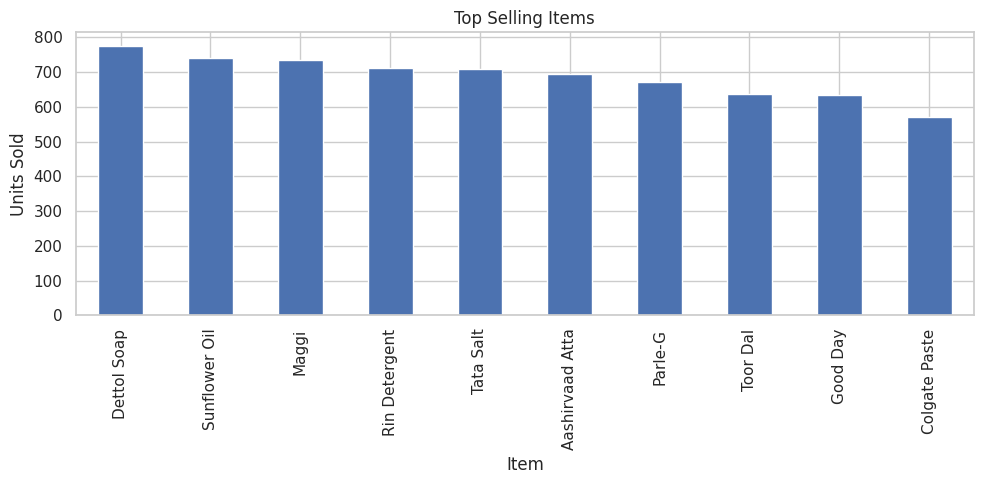

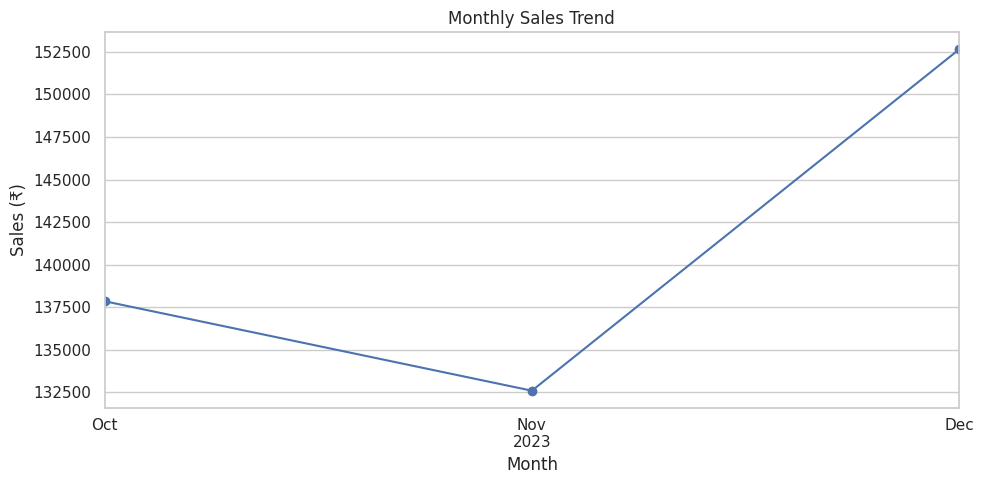

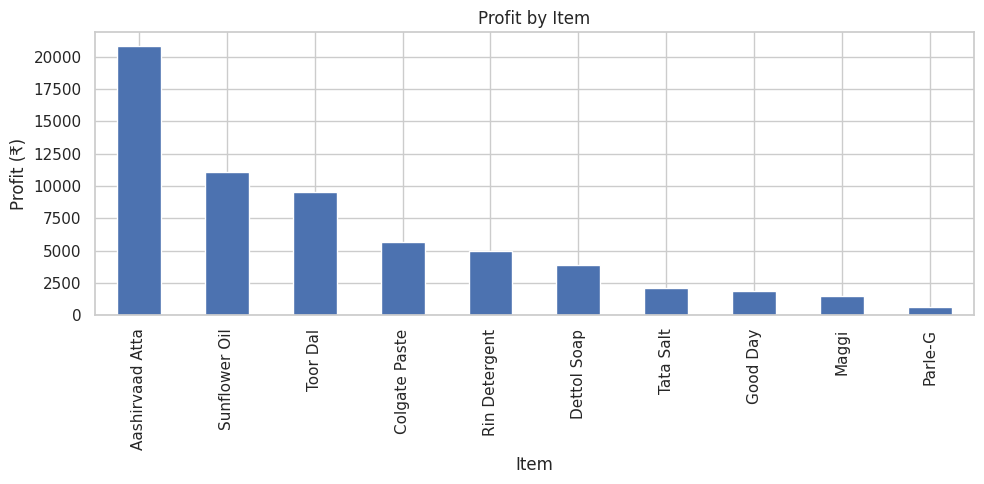

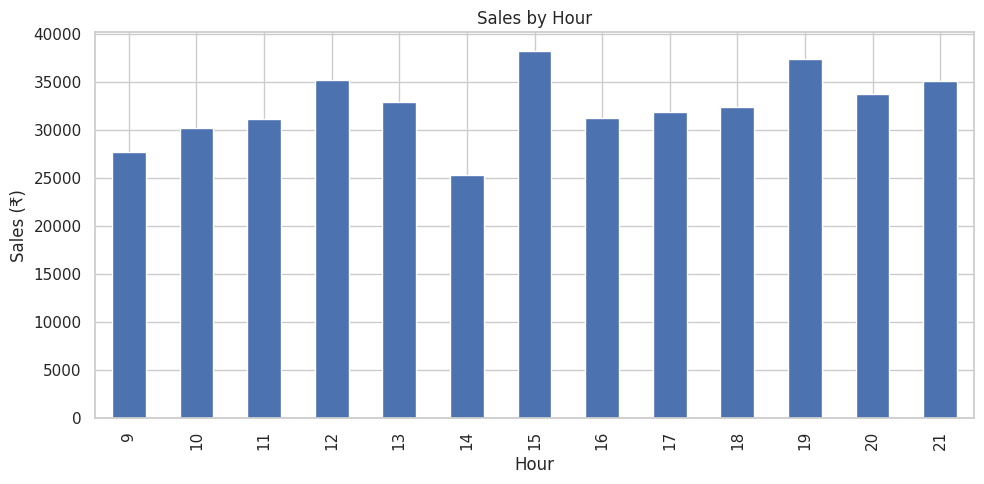

In [7]:
# 7. VISUALIZATION
# ---------------------------------------------
# Top Selling Items
top_items.plot(kind="bar", title="Top Selling Items")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.savefig("top_selling_items.png")
plt.show()

# Monthly Sales Trend
monthly_sales.plot(marker="o", title="Monthly Sales Trend")
plt.ylabel("Sales (₹)")
plt.tight_layout()
plt.savefig("monthly_sales_trend.png")
plt.show()

# Profit by Item
profit_items.plot(kind="bar", title="Profit by Item")
plt.ylabel("Profit (₹)")
plt.tight_layout()
plt.savefig("profit_by_item.png")
plt.show()

# Hourly Sales
hourly_sales.plot(kind="bar", title="Sales by Hour")
plt.ylabel("Sales (₹)")
plt.tight_layout()
plt.savefig("sales_by_hour.png")
plt.show()

In [8]:
# 8. CONCLUSION & OUTPUT
# ---------------------------------------------
print("\nTop 5 Selling Items:\n", top_items.head())
print("\nSlowest 5 Selling Items:\n", slow_items)
print("\nMost Profitable Items:\n", profit_items.head())
print("\nPeak Sales Hours:\n", hourly_sales.sort_values(ascending=False).head())
print("\nTop Supplier by Quantity:\n", supplier_perf.sort_values(by="Quantity", ascending=False).head())

print("\nMost Frequent Item Combinations:")
for combo, count in top_combos:
    print(f"{combo}: {count} times")


Top 5 Selling Items:
 Item
Dettol Soap      776
Sunflower Oil    741
Maggi            735
Rin Detergent    713
Tata Salt        710
Name: Quantity, dtype: int64

Slowest 5 Selling Items:
 Item
Colgate Paste      570
Good Day           633
Toor Dal           638
Parle-G            673
Aashirvaad Atta    695
Name: Quantity, dtype: int64

Most Profitable Items:
 Item
Aashirvaad Atta    20850
Sunflower Oil      11115
Toor Dal            9570
Colgate Paste       5700
Rin Detergent       4991
Name: Profit, dtype: int64

Peak Sales Hours:
 Hour
15    38306
19    37440
12    35291
21    35172
20    33776
Name: Total_Sale, dtype: int64

Top Supplier by Quantity:
             Quantity  Total_Cost
Supplier                        
HUL             1489       45907
PureOil Co       741       81510
Nestle           735        7350
Tata             710       12070
ITC              695      125100

Most Frequent Item Combinations:
('Dettol Soap', 'Maggi'): 64 times
('Rin Detergent', 'Sunflower Oil'): 